In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

from utils.data import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

%load_ext autoreload
%autoreload 2

cuda


# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'Circles'
#DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=0.5)

[[  0  97]
 [  1 103]]
(200, 1, 28, 28)
torch.Size([157, 1, 28, 28]) torch.Size([40, 1, 28, 28])
tensor(0.) tensor(1.)
CPU times: user 423 ms, sys: 99.6 ms, total: 522 ms
Wall time: 411 ms


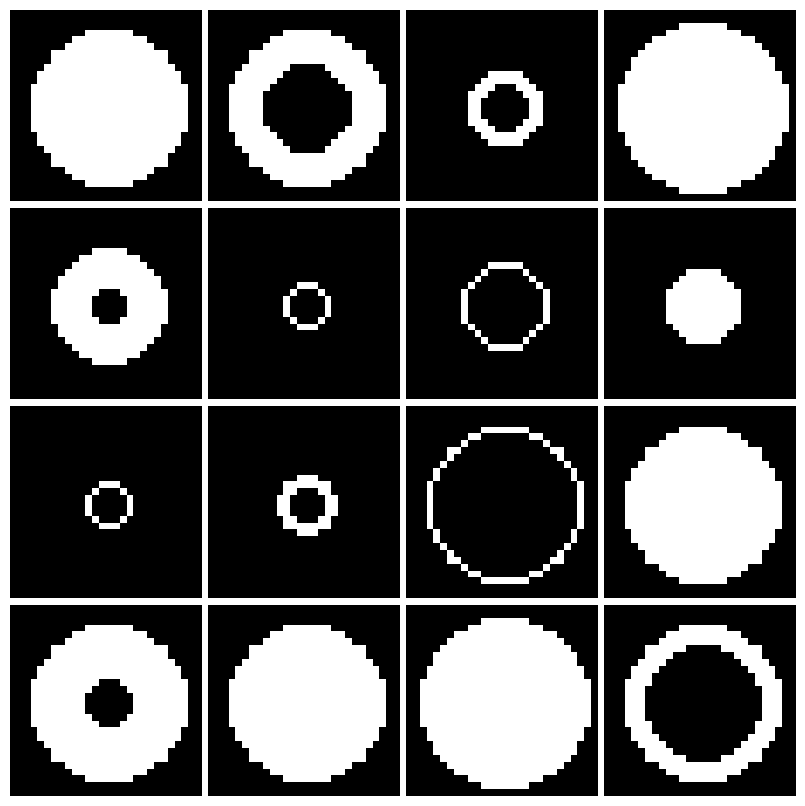

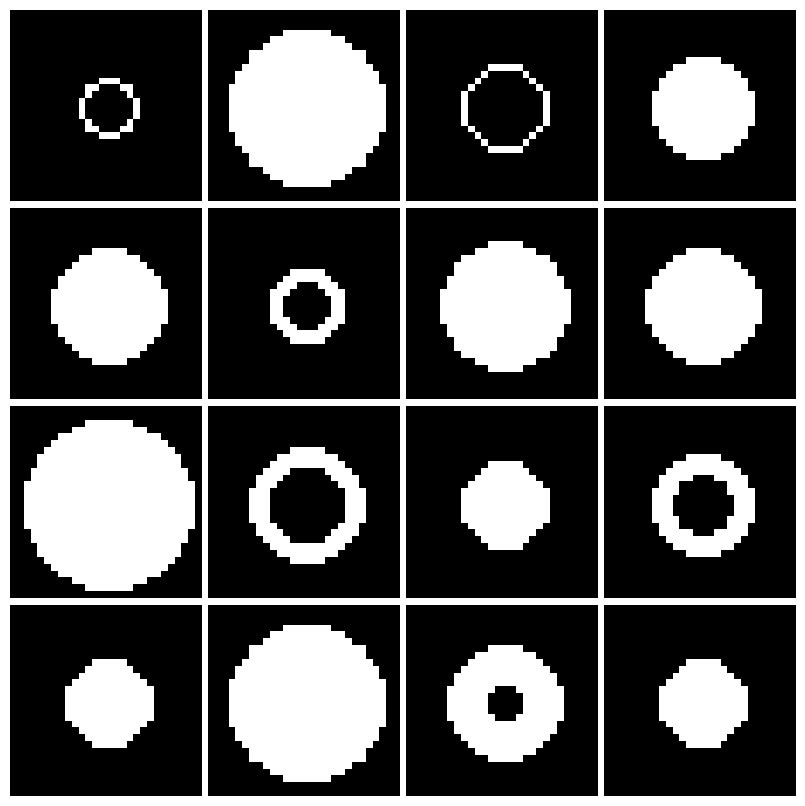

In [4]:
%%time

if DATA_SET == 'Circles' :
    shapes, targets = gen_circles_dataset(num_images=200, seed=42)
    print(np.array(np.unique(targets, return_counts=True)).T)
    
    shapes = shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    subsampled_indeces = sample_indices(targets, k=100, max_classes=None, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    # train_indeces = sample_indices(targets, k=90, seed=42)
    # remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    # test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
    subsampled_indeces = sample_indices(targets, k=100, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    # train_indeces = sample_indices(mnist_trainset.targets, k=500, max_classes=2, seed=42)
    # remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    # test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=50, seed=42)

    subsampled_indeces = sample_indices(mnist_trainset.targets, k=1000, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

    train_labels = mnist_trainset.targets[train_indeces]
    eval_labels = mnist_trainset.targets[test_indeces]

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

plot_grid(train_dataset)
plot_grid(eval_dataset)

In [5]:
print(train_dataset.shape, train_dataset.min(), train_dataset.max(), train_dataset.mean(), train_dataset.std())
print(eval_dataset.shape, eval_dataset.min(), eval_dataset.max(), eval_dataset.mean(), eval_dataset.std())

torch.Size([157, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2111) tensor(0.4081)
torch.Size([40, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2741) tensor(0.4461)


In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }

In [8]:
model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=2,
    reconstruction_loss="bce",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-3
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=2,
#     reconstruction_loss="bce",
# )

# model = VAE(
#     model_config=model_config,
#     encoder=architecture_dict['tiny']['encoder'](model_config),
#     decoder=architecture_dict['tiny']['decoder'](model_config),
# )

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 70 µs, sys: 23 µs, total: 93 µs
Wall time: 95.8 µs


946391

In [10]:
print(model)

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)


## Train

In [11]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.trainers.training_callbacks import TrainHistoryCallback
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=200,
    learning_rate=1e-3,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    #optimizer_cls="AdamW",
    #optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 10, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

callbacks = []
history_cb = TrainHistoryCallback()
callbacks = callbacks.append(history_cb)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-06-10_13-46-11. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 200
 - per_device_train_batch_size: 157
 - per_device_eval_batch_size: 40
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f4d711c0c40>

Successfully launched training !



Training of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 566.8508
Eval loss: 527.7197
--------------------------------------------------------------------------


Training of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 529.5619
Eval loss: 503.6047
--------------------------------------------------------------------------


Training of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 503.4205
Eval loss: 466.7623
--------------------------------------------------------------------------


Training of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 474.543
Eval loss: 445.8443
--------------------------------------------------------------------------


Training of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 446.4027
Eval loss: 420.9009
--------------------------------------------------------------------------


Training of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 419.9319
Eval loss: 393.9825
--------------------------------------------------------------------------


Training of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 384.6265
Eval loss: 353.8532
--------------------------------------------------------------------------


Training of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 359.9302
Eval loss: 328.1369
--------------------------------------------------------------------------


Training of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 340.0553
Eval loss: 332.1028
--------------------------------------------------------------------------


Training of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 307.8402
Eval loss: 314.2326
--------------------------------------------------------------------------


Training of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 297.7176
Eval loss: 267.1555
--------------------------------------------------------------------------


Training of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 280.7177
Eval loss: 251.4522
--------------------------------------------------------------------------


Training of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 262.1419
Eval loss: 264.3276
--------------------------------------------------------------------------


Training of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 248.8216
Eval loss: 240.0178
--------------------------------------------------------------------------


Training of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 244.5333
Eval loss: 239.2096
--------------------------------------------------------------------------


Training of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 235.4694
Eval loss: 232.933
--------------------------------------------------------------------------


Training of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 222.4133
Eval loss: 232.3347
--------------------------------------------------------------------------


Training of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 208.9341
Eval loss: 233.8203
--------------------------------------------------------------------------


Training of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.8445
Eval loss: 229.2963
--------------------------------------------------------------------------


Training of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.0956
Eval loss: 231.7349
--------------------------------------------------------------------------


Training of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 191.8095
Eval loss: 218.7739
--------------------------------------------------------------------------


Training of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 190.4984
Eval loss: 205.1227
--------------------------------------------------------------------------


Training of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 189.113
Eval loss: 207.7328
--------------------------------------------------------------------------


Training of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.6756
Eval loss: 189.0928
--------------------------------------------------------------------------


Training of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.332
Eval loss: 190.694
--------------------------------------------------------------------------


Training of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.8583
Eval loss: 169.3046
--------------------------------------------------------------------------


Training of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.9293
Eval loss: 157.1049
--------------------------------------------------------------------------


Training of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 159.3499
Eval loss: 155.4522
--------------------------------------------------------------------------


Training of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 156.4303
Eval loss: 141.5592
--------------------------------------------------------------------------


Training of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 151.5991
Eval loss: 131.7668
--------------------------------------------------------------------------


Training of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.1564
Eval loss: 128.3119
--------------------------------------------------------------------------


Training of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 139.4398
Eval loss: 129.3123
--------------------------------------------------------------------------


Training of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 136.1575
Eval loss: 125.389
--------------------------------------------------------------------------


Training of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 132.2924
Eval loss: 117.4351
--------------------------------------------------------------------------


Training of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.961
Eval loss: 118.7711
--------------------------------------------------------------------------


Training of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.599
Eval loss: 114.2946
--------------------------------------------------------------------------


Training of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.914
Eval loss: 112.4779
--------------------------------------------------------------------------


Training of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.2969
Eval loss: 110.9739
--------------------------------------------------------------------------


Training of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 118.1708
Eval loss: 107.1952
--------------------------------------------------------------------------


Training of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 113.0461
Eval loss: 106.315
--------------------------------------------------------------------------


Training of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 113.895
Eval loss: 104.4023
--------------------------------------------------------------------------


Training of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 110.8077
Eval loss: 105.6754
--------------------------------------------------------------------------


Training of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 107.2737
Eval loss: 102.3333
--------------------------------------------------------------------------


Training of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 104.7502
Eval loss: 100.1601
--------------------------------------------------------------------------


Training of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 103.451
Eval loss: 100.0267
--------------------------------------------------------------------------


Training of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.1861
Eval loss: 96.4433
--------------------------------------------------------------------------


Training of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 98.7765
Eval loss: 96.1233
--------------------------------------------------------------------------


Training of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 97.791
Eval loss: 93.3402
--------------------------------------------------------------------------


Training of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 95.9171
Eval loss: 92.122
--------------------------------------------------------------------------


Training of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 93.4736
Eval loss: 90.0179
--------------------------------------------------------------------------


Training of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 91.4393
Eval loss: 88.8966
--------------------------------------------------------------------------


Training of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.4778
Eval loss: 85.9469
--------------------------------------------------------------------------


Training of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 86.7409
Eval loss: 85.2403
--------------------------------------------------------------------------


Training of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 85.6634
Eval loss: 84.5627
--------------------------------------------------------------------------


Training of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.4006
Eval loss: 84.1393
--------------------------------------------------------------------------


Training of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.1851
Eval loss: 81.0786
--------------------------------------------------------------------------


Training of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.1132
Eval loss: 81.1477
--------------------------------------------------------------------------


Training of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 79.4873
Eval loss: 80.0996
--------------------------------------------------------------------------


Training of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.3234
Eval loss: 77.8074
--------------------------------------------------------------------------


Training of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 77.7874
Eval loss: 77.3417
--------------------------------------------------------------------------


Training of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.421
Eval loss: 77.0664
--------------------------------------------------------------------------


Training of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 75.8388
Eval loss: 76.7873
--------------------------------------------------------------------------


Training of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 74.421
Eval loss: 77.6786
--------------------------------------------------------------------------


Training of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 73.7749
Eval loss: 75.3277
--------------------------------------------------------------------------


Training of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 73.0239
Eval loss: 74.1352
--------------------------------------------------------------------------


Training of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.2481
Eval loss: 74.3358
--------------------------------------------------------------------------


Training of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.5143
Eval loss: 72.6851
--------------------------------------------------------------------------


Training of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.8322
Eval loss: 72.4566
--------------------------------------------------------------------------


Training of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.1229
Eval loss: 72.0175
--------------------------------------------------------------------------


Training of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.6069
Eval loss: 72.2952
--------------------------------------------------------------------------


Training of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.1519
Eval loss: 73.1593
--------------------------------------------------------------------------


Training of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.9379
Eval loss: 73.8629
--------------------------------------------------------------------------


Training of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.4675
Eval loss: 69.9686
--------------------------------------------------------------------------


Training of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.3842
Eval loss: 70.4187
--------------------------------------------------------------------------


Training of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.2506
Eval loss: 67.7566
--------------------------------------------------------------------------


Training of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.7147
Eval loss: 67.2
--------------------------------------------------------------------------


Training of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.9543
Eval loss: 65.9089
--------------------------------------------------------------------------


Training of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.9382
Eval loss: 66.9009
--------------------------------------------------------------------------


Training of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.4918
Eval loss: 66.4301
--------------------------------------------------------------------------


Training of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.742
Eval loss: 65.7472
--------------------------------------------------------------------------


Training of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.8927
Eval loss: 64.0013
--------------------------------------------------------------------------


Training of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.2055
Eval loss: 63.841
--------------------------------------------------------------------------


Training of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.463
Eval loss: 66.4106
--------------------------------------------------------------------------


Training of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.3384
Eval loss: 63.363
--------------------------------------------------------------------------


Training of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.4499
Eval loss: 60.7481
--------------------------------------------------------------------------


Training of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.2032
Eval loss: 62.2968
--------------------------------------------------------------------------


Training of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.1559
Eval loss: 62.1195
--------------------------------------------------------------------------


Training of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.7243
Eval loss: 60.8777
--------------------------------------------------------------------------


Training of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.5472
Eval loss: 59.3295
--------------------------------------------------------------------------


Training of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.917
Eval loss: 60.1714
--------------------------------------------------------------------------


Training of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.6237
Eval loss: 58.6207
--------------------------------------------------------------------------


Training of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.2356
Eval loss: 59.1792
--------------------------------------------------------------------------


Training of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.0308
Eval loss: 58.0678
--------------------------------------------------------------------------


Training of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.6188
Eval loss: 57.7541
--------------------------------------------------------------------------


Training of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.9267
Eval loss: 58.4863
--------------------------------------------------------------------------


Training of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.1491
Eval loss: 57.3263
--------------------------------------------------------------------------


Training of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.0982
Eval loss: 57.5645
--------------------------------------------------------------------------


Training of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.0169
Eval loss: 55.7509
--------------------------------------------------------------------------


Training of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.282
Eval loss: 55.9388
--------------------------------------------------------------------------


Training of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.9773
Eval loss: 55.8487
--------------------------------------------------------------------------


Training of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.6106
Eval loss: 55.3646
--------------------------------------------------------------------------


Training of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.6822
Eval loss: 57.0135
--------------------------------------------------------------------------


Training of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.7277
Eval loss: 54.5594
--------------------------------------------------------------------------


Training of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.2176
Eval loss: 55.3349
--------------------------------------------------------------------------


Training of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.2534
Eval loss: 54.1618
--------------------------------------------------------------------------


Training of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.3433
Eval loss: 54.3597
--------------------------------------------------------------------------


Training of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.2293
Eval loss: 53.7052
--------------------------------------------------------------------------


Training of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.0338
Eval loss: 53.0884
--------------------------------------------------------------------------


Training of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.9577
Eval loss: 53.6875
--------------------------------------------------------------------------


Training of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.6948
Eval loss: 53.1388
--------------------------------------------------------------------------


Training of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.9057
Eval loss: 52.2049
--------------------------------------------------------------------------


Training of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.89
Eval loss: 52.9399
--------------------------------------------------------------------------


Training of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.1002
Eval loss: 52.1524
--------------------------------------------------------------------------


Training of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.7762
Eval loss: 50.7205
--------------------------------------------------------------------------


Training of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.483
Eval loss: 51.0846
--------------------------------------------------------------------------


Training of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.0431
Eval loss: 50.3892
--------------------------------------------------------------------------


Training of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.9778
Eval loss: 51.1356
--------------------------------------------------------------------------


Training of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.9494
Eval loss: 49.1061
--------------------------------------------------------------------------


Training of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.3539
Eval loss: 49.9803
--------------------------------------------------------------------------


Training of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.6266
Eval loss: 49.569
--------------------------------------------------------------------------


Training of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.7993
Eval loss: 48.869
--------------------------------------------------------------------------


Training of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.5398
Eval loss: 49.1759
--------------------------------------------------------------------------


Training of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.032
Eval loss: 49.405
--------------------------------------------------------------------------


Training of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.4119
Eval loss: 48.1494
--------------------------------------------------------------------------


Training of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.352
Eval loss: 48.352
--------------------------------------------------------------------------


Training of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.0026
Eval loss: 47.9207
--------------------------------------------------------------------------


Training of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.6373
Eval loss: 49.3601
--------------------------------------------------------------------------


Training of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.1863
Eval loss: 46.8487
--------------------------------------------------------------------------


Training of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.0637
Eval loss: 46.6698
--------------------------------------------------------------------------


Training of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.3499
Eval loss: 48.2843
--------------------------------------------------------------------------


Training of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.3611
Eval loss: 46.5597
--------------------------------------------------------------------------


Training of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.7988
Eval loss: 46.4205
--------------------------------------------------------------------------


Training of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.1008
Eval loss: 46.7094
--------------------------------------------------------------------------


Training of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.2315
Eval loss: 46.0049
--------------------------------------------------------------------------


Training of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.6365
Eval loss: 45.7653
--------------------------------------------------------------------------


Training of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.1967
Eval loss: 44.8074
--------------------------------------------------------------------------


Training of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6169
Eval loss: 45.5936
--------------------------------------------------------------------------


Training of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7913
Eval loss: 46.3127
--------------------------------------------------------------------------


Training of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5982
Eval loss: 46.6874
--------------------------------------------------------------------------


Training of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6764
Eval loss: 44.0894
--------------------------------------------------------------------------


Training of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3123
Eval loss: 44.7999
--------------------------------------------------------------------------


Training of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.7734
Eval loss: 44.9991
--------------------------------------------------------------------------


Training of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.7663
Eval loss: 44.5781
--------------------------------------------------------------------------


Training of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8666
Eval loss: 43.4406
--------------------------------------------------------------------------


Training of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.6993
Eval loss: 44.8242
--------------------------------------------------------------------------


Training of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.0987
Eval loss: 44.2763
--------------------------------------------------------------------------


Training of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.0561
Eval loss: 43.6082
--------------------------------------------------------------------------


Training of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.8544
Eval loss: 43.3277
--------------------------------------------------------------------------


Training of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.6398
Eval loss: 42.5438
--------------------------------------------------------------------------


Training of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4124
Eval loss: 42.6727
--------------------------------------------------------------------------


Training of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.1085
Eval loss: 43.0586
--------------------------------------------------------------------------


Training of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.3817
Eval loss: 42.4131
--------------------------------------------------------------------------


Training of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.4784
Eval loss: 42.4161
--------------------------------------------------------------------------


Training of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.9368
Eval loss: 42.8385
--------------------------------------------------------------------------


Training of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.7191
Eval loss: 41.8006
--------------------------------------------------------------------------


Training of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.3012
Eval loss: 41.7195
--------------------------------------------------------------------------


Training of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.2838
Eval loss: 41.0238
--------------------------------------------------------------------------


Training of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.5333
Eval loss: 41.892
--------------------------------------------------------------------------


Training of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.5168
Eval loss: 41.6461
--------------------------------------------------------------------------


Training of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.0623
Eval loss: 41.3862
--------------------------------------------------------------------------


Training of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.1443
Eval loss: 39.9391
--------------------------------------------------------------------------


Training of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.1749
Eval loss: 39.8747
--------------------------------------------------------------------------


Training of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.1304
Eval loss: 40.5592
--------------------------------------------------------------------------


Training of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.6916
Eval loss: 40.3265
--------------------------------------------------------------------------


Training of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.2405
Eval loss: 39.4717
--------------------------------------------------------------------------


Training of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.4439
Eval loss: 40.1115
--------------------------------------------------------------------------


Training of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.15
Eval loss: 38.812
--------------------------------------------------------------------------


Training of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.0298
Eval loss: 38.7131
--------------------------------------------------------------------------


Training of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.6316
Eval loss: 39.1608
--------------------------------------------------------------------------


Training of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.7634
Eval loss: 38.8137
--------------------------------------------------------------------------


Training of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.4515
Eval loss: 38.3256
--------------------------------------------------------------------------


Training of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.1125
Eval loss: 38.1173
--------------------------------------------------------------------------


Training of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.8641
Eval loss: 38.0916
--------------------------------------------------------------------------


Training of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.7944
Eval loss: 38.0026
--------------------------------------------------------------------------


Training of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.6095
Eval loss: 37.8039
--------------------------------------------------------------------------


Training of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.3717
Eval loss: 38.0731
--------------------------------------------------------------------------


Training of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.6144
Eval loss: 37.768
--------------------------------------------------------------------------


Training of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.4578
Eval loss: 37.4425
--------------------------------------------------------------------------


Training of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.2137
Eval loss: 37.3242
--------------------------------------------------------------------------


Training of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.8964
Eval loss: 37.3285
--------------------------------------------------------------------------


Training of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.7158
Eval loss: 37.4484
--------------------------------------------------------------------------


Training of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.4612
Eval loss: 37.0255
--------------------------------------------------------------------------


Training of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.3398
Eval loss: 36.3375
--------------------------------------------------------------------------


Training of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.6853
Eval loss: 36.7074
--------------------------------------------------------------------------


Training of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.4502
Eval loss: 36.5332
--------------------------------------------------------------------------


Training of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.6816
Eval loss: 36.3607
--------------------------------------------------------------------------


Training of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.7649
Eval loss: 36.8582
--------------------------------------------------------------------------


Training of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.6077
Eval loss: 35.7368
--------------------------------------------------------------------------


Training of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.6056
Eval loss: 35.5764
--------------------------------------------------------------------------


Training of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.3918
Eval loss: 35.6978
--------------------------------------------------------------------------


Training of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.3565
Eval loss: 36.105
--------------------------------------------------------------------------


Training of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.5076
Eval loss: 35.6864
--------------------------------------------------------------------------


Training of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.2212
Eval loss: 35.7882
--------------------------------------------------------------------------


Training of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.5113
Eval loss: 36.3522
--------------------------------------------------------------------------


Training of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.789
Eval loss: 36.0024
--------------------------------------------------------------------------


Training of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.8613
Eval loss: 35.4418
--------------------------------------------------------------------------


Training of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.8975
Eval loss: 36.3347
--------------------------------------------------------------------------


Training of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.9529
Eval loss: 34.8099
--------------------------------------------------------------------------


Training of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.4901
Eval loss: 35.0022
--------------------------------------------------------------------------


Training of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1602
Eval loss: 35.3921
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-06-10_13-46-11/final_model


CPU times: user 38.1 s, sys: 935 ms, total: 39 s
Wall time: 40.4 s


## Loss History

In [12]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, history_cb.history['train_loss'], label='Training Loss', marker='o')
plt.plot(epochs, history_cb.history['eval_loss'], label='Evaluation Loss', marker='x')

# Add titles and labels
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

NameError: name 'epochs' is not defined

<Figure size 1000x600 with 0 Axes>

## Trained Model

In [ ]:
from pythae.models import AutoModel

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])
    #trained_model = AutoModel.load_from_hf_hub(hf_hub_path="clementchadebec/reproduced_vae", allow_pickle=True)

# LATENT SPACE

In [ ]:
# latents = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(latents[:, 0], latents[:, 1], c=eval_labels, cmap='viridis', marker='o')
# legend = plt.legend(*scatter.legend_elements(), title="Classes")


In [ ]:
# Extract latent space representations
z_mean = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()
z_log_var = trained_model.encoder(eval_dataset.to(device)).log_covariance.detach().cpu().numpy()
y_test = eval_labels

# Plotting the latent space
def plot_cov_ellipse(mean, cov, ax, color='gray', nstd=1.0, **kwargs):
    """Plots an ellipse representing the covariance matrix."""
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=color, edgecolor='none', **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * nstd
    scale_y = np.sqrt(cov[1, 1]) * nstd
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean[0], mean[1])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot covariance ellipses
for i in range(len(z_mean)):
    cov = np.diag(np.exp(z_log_var[i]))
    plot_cov_ellipse(z_mean[i], cov, ax, color='gray', alpha=0.2)
    
scatter = ax.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=1)
legend = plt.legend(*scatter.legend_elements(), title="Classes")

plt.colorbar(scatter, ax=ax)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Latent Space of VAE with Covariance Ellipses')
plt.show()

In [ ]:
trained_model
# 'centroids',
 # 'centroids_tens', 
 # 'metric', 
 # 'G',
 # 'G_inv',
 # 'M',
 # 'M_tens',
 # 'T_destination',

# RECONSTRUCTIONS

In [ ]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

# INTERPOLATIONS

In [ ]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Metrics

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# FID score computation class
fid_calculator = FrechetInceptionDistance(feature=64, reset_real_features=False, normalize=True)
fid_calculator.update(train_dataset.expand(train_dataset.shape[0], 3, 28, 28)[:200,].to('cpu'), real=True)

# IS score computation class
is_calculator = InceptionScore(normalize=True)

def compute_fid_score(gen_data):
    # Lower is better
    # greater sample variety
    fid_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu(), real=False)
    fid_score = fid_calculator.compute().item()
    print(f"FID = {fid_score:.4f}")
    return fid_score

def compute_is_score(gen_data):
    # Higher is better
    # better quality within individual images
    is_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu())
    is_score = is_calculator.compute()
    print(f"IS [mean] = {is_score[0].item():.4f}")
    print(f"IS [std] = {is_score[1].item():.4f}")


## Generators

### Normal Sampler

In [ ]:
from pythae.samplers import NormalSampler

sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

In [ ]:
plot_grid(gen_data.data.cpu())
compute_fid_score(gen_data)
compute_is_score(gen_data)

### Gaussian Mixture Model Sampler

In [ ]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=2
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

In [ ]:
plot_grid(gmm_gen_data.data.cpu())
compute_fid_score(gmm_gen_data)
compute_is_score(gmm_gen_data)

### RHVAE Sampler

In [ ]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig

rh_sampler_config = RHVAESamplerConfig(
    mcmc_steps_nbr = 100,
    n_lf = 15,
    eps_lf = 1e-3,
    beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

In [ ]:
plot_grid(rh_gen_data.cpu())
compute_fid_score(rh_gen_data)
compute_is_score(rh_gen_data)